<a href="https://colab.research.google.com/github/quangtrung0220/SieuAmTim/blob/master/SieuAmTim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt

from collections import namedtuple

from sklearn.metrics import classification_report

import cv2

import numpy as np




In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def get_clases():
  classes = ['2C', '3C', '4C']
  return classes

TrainTest = namedtuple('TrainTest', ['train', 'test'])

def prepare_data():
  transform_train = transforms.Compose([
    transforms.Resize((224,224)),                                    
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
  ])
  transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
  ])
  trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/train', transform=transform_train)
  testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/test', transform=transform_test)
  return TrainTest(train=trainset, test=testset)

def prepare_loader(datasets):
  trainloader = DataLoader(dataset=datasets.train, batch_size=35, shuffle=True, num_workers=4)
  testloader = DataLoader(dataset=datasets.test, batch_size=35, shuffle=False, num_workers=4)
  return TrainTest(train=trainloader, test=testloader)

In [7]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  true_result = []
  pred_result = []
  model.train()
  running_loss = 0.0
  reporting_steps = 18
  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    true_result += list(labels.cpu().numpy())
    _, predicted = torch.max(outputs, dim=1)
    pred_result += list(predicted.cpu().numpy())
    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % reporting_steps == reporting_steps-1:
      print(f"Epoch {epoch} step {i} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  return pred_result, true_result

def test_epoch(epoch, model, loader, device):
  ytrue = []
  ypred = []
  with torch.no_grad():
    model.eval()
    
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)

      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())

  return ypred, ytrue

In [8]:
def main(PATH='./model.pth', model_in=''):
  classes = get_clases()
  datasets = prepare_data()
  # img, label = datasets.train[0]
  # plt.imshow(img)
  # print(classes[label], img.size)
  # print('train', len(datasets.train), 'test', len(datasets.test))
  
  loaders = prepare_loader(datasets)

  # images, labels = iter(loaders.train).next()
  # print(images.shape, labels.shape)

  device = torch.device("cuda:0")
  torch.cuda.empty_cache()

  # model = ResNet50().to(device)
  # model = VGG16().to(device)
  # images, labels = iter(loaders.train).next()
  # outputs = model(images)
  # print(outputs.shape)
  # print(outputs[0])
  # _, predicted = torch.max(outputs, dim=1)
  # print(predicted)
  # imshow(images, labels, predicted, classes)

  if model_in == 'vgg16':
    model = torchvision.models.vgg16()
    model.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    if torch.cuda.is_available():
      model.to(device=device)
  elif model_in == 'resnet50':
    model = torchvision.models.resnet50(pretrained=False, progress=False)
    model.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True)  
    if torch.cuda.is_available():
      model.to(device=device)
  elif model_in == 'desnet':
    model = torchvision.models.densenet121(pretrained=False, progress=False)
    model.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    if torch.cuda.is_available():
      model.to(device=device)
  else:
    pass  

  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  for epoch in range(10):
    print(f'Epoch {epoch} report: ')
    
    pred_result, true_result = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    print('Train report: ')
    print(classification_report(true_result, pred_result, target_names=classes))

    print('Test report: ')
    ypred, ytrue = test_epoch(epoch, model, loaders.test, device)
    print(classification_report(ytrue, ypred, target_names=classes))

    torch.save(model.state_dict(), PATH)

  return model

model = main(model_in='desnet')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 report: 


KeyboardInterrupt: ignored

In [14]:
! git
! git init
! git clone https://github.com/quangtrung0220/SieuAmTim.git
! pwd
%cd SieuAmTim/
! gitgit remote -v
! git status

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect     Use binary search to find the commit that introduced a bug
   grep       Prin

In [6]:
class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = self._make_features()
    self.classification_head = nn.Linear(in_features=512, out_features=3)

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size(0), -1)
    out = self.classification_head(out)
    return out

  def _make_features(self):
    config = [64,64,'MP',128,128,'MP',256,256,256,'MP',512,512,512,'MP',512,512,512,'MP']
    layers = []
    c_in = 3
    for c in config:
      if c == 'MP':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        layers += [nn.Conv2d(in_channels=c_in, out_channels=c, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(num_features=c),
                   nn.ReLU6(inplace=True)]
        c_in = c
    return nn.Sequential(*layers)

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

def ResNet50(num_classes=3, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)





/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 report: 
Epoch 0 step 17 ave_loss 1.0953
Epoch 0 step 35 ave_loss 0.8687
Epoch 0 step 53 ave_loss 0.6322
Epoch 0 step 71 ave_loss 0.4065
Epoch 0 step 89 ave_loss 0.3050
Epoch 0 step 107 ave_loss 0.2538
Epoch 0 step 125 ave_loss 0.1551
Epoch 0 step 143 ave_loss 0.2175
Epoch 0 step 161 ave_loss 0.2780
Epoch 0 step 179 ave_loss 0.1242
Train report: 
              precision    recall  f1-score   support

          2C       0.81      0.83      0.82      2377
          3C       0.83      0.80      0.81      2309
          4C       0.83      0.84      0.83      2031

    accuracy                           0.82      6717
   macro avg       0.82      0.82      0.82      6717
weighted avg       0.82      0.82      0.82      6717

Test report: 
              precision    recall  f1-score   support

          2C       0.27      1.00      0.43       409
          3C       1.00      0.06      0.12       367
          4C       1.00      0.10      0.18       831

    accuracy                  

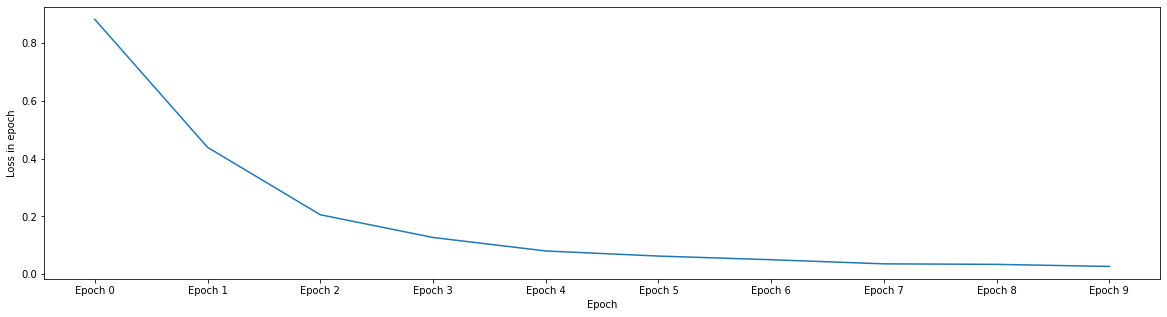

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# # # show images
# # classes = get_classes()
# # imshow(torchvision.utils.make_grid(images))
# # print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
def main(PATH='./model.pth'):

  loss_tr = [0.8819, 0.4390, 0.2056, 0.1269, 0.0802, 0.0625, 0.0499, 
          0.0356, 0.0338, 0.0266]
          # , 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001,
          # 0.0002, 0.0001, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0001, 0.0001, 0.0001]

  loss_te = [69, 67, 71, 74, 72, 77, 75, 
          78, 82, 78, 75, 75]

  time = [0,1,2,3,4,5,6,7,8,9]
  # ,10,10,11,11,12,12,13,13,14,14,15,15,16,16,17,17,18,18,19,19]        
  labels = ['Epoch 0', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8', 'Epoch 9', 'Epoch 10', 'Epoch 11']
          # ,
          # '10 - step 17', '10 - step 35', '11 - step 17', '11 - step 35', '12 - step 17', '12 - step 35', '13 - step 17', '13 - step 35', '14 - step 17', '14 - step 35',
          # '15 - step 17', '15 - step 35', '17 - step 17', '17 - step 35', '18 - step 17', '18 - step 35', '19 - step 17', '19 - step 35']

  position = []
  for i in range(40):
    position.append(i)

  plt.figure(figsize=(20, 5))
  plt.xticks(position, labels)

  plt.xlabel("Epoch")
  plt.ylabel("Loss in epoch")
  plt.plot(time, loss_tr)
  plt.show()

  # plt.figure(figsize=(20, 5))
  # plt.xticks(position, labels)

  # plt.xlabel("Epoch")
  # plt.ylabel("Accuracy (%)")
  # plt.plot(time, loss_te)
  # plt.show()

  print(torchvision.models.resnet50())

model = main()